# Definition

## Project Overview
This is a competition from Kaggle, [Kobe Bryant Shot Selection](https://www.kaggle.com/c/kobe-bryant-shot-selection). The description of this problem from Kaggle is as follows.
> Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.
Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net?


## Problem Statement
> Given location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career, the task is to predict the probability that Kobe made the field goal. 

This is a classification problem, but the classification algorithm should be able to give the probability for each class. To solve this problem, first I will do some data exploration, we all know that the shot percentage depends on all kinds of features, such as shot type, shot distance, the state of the athlete and so on, some statistics will be made to understand the importance of each feature. Then I will try different kinds of supervised learning classification algorithms, and tune the model using cross validation, then choose the best model, and train it on the whole data sets, finally use this model to generate the precdictions on test data. And try to rank as high as possible in the competion.

## Metrics
The metrics I use will follow the competition metrics, [log loss](https://www.kaggle.com/wiki/LogarithmicLoss)
> The logarithm of the likelihood function for a Bernouli random distribution.
In plain English, this error metric is used where contestants have to predict that something is true or false with a probability (likelihood) ranging from definitely true (1) to equally true (0.5) to definitely false(0).
> The use of log on the error provides extreme punishments for being both confident and wrong. In the worst possible case, a single prediction that something is definitely true (1) when it is actually false will add infinite to your error score and make every other entry pointless. In Kaggle competitions, predictions are bounded away from the extremes by a small value in order to prevent this.


# Analysis
## Data Exploration

In [1]:
import csv
import pandas as pd

In [39]:
all_data = pd.read_csv('data.csv')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

There are 24 features whose name are self explanatory, and shot_made_flag is our prediction target. There are 30697 entries, and 5000 entries don't have label, which means the size of training data is 25697, and size of test data is 5000. There is no missing value, so we don't have to worry about this. 

In [28]:
all_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


<strong>action_type, combined_shot_type, season, shot_type, shot_zone_area, shot_zone_basic, shot_zone_range, team_name, game_date, matchup, opponent</strong>, these categorical variables need to be transformed using one hot encoding. <strong>team_name and team_id</strong> is always "Los Angeles Lakers", so it can be droped. <strong>game_date</strong> is time series, so it can be change to ordered number. <strong>matchup</strong> should be transformed to a new feature, whether the competion is held home. <strong>game_event_id</strong> is global, it should be localised for kobe. <strong>game_id</strong> is useless, because we have game_date, and there is only one game a day. <strong>lat , lon, shot_id</strong> are useless, can be droped.

In [29]:
all_data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


From shot_distance we can see kobe likes to make close range shot, other statistic results don't have much meaning. 

## Exploratory Visualization


The visualization scrip is borrowed from [a kaggle scrip](https://www.kaggle.com/selfishgene/kobe-bryant-shot-selection/psychology-of-a-professional-athlete).First, let's examine the temporal aspect of Kobe's shots.

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn import mixture
from matplotlib.patches import Circle, Rectangle, Arc
%matplotlib inline

data = all_data[all_data['shot_made_flag'].notnull()].reset_index()
#%% add some temporal columns to the data

data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek'] = data['game_date_DT'].dt.dayofweek
data['dayOfYear'] = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd'] = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart'] = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 
    4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

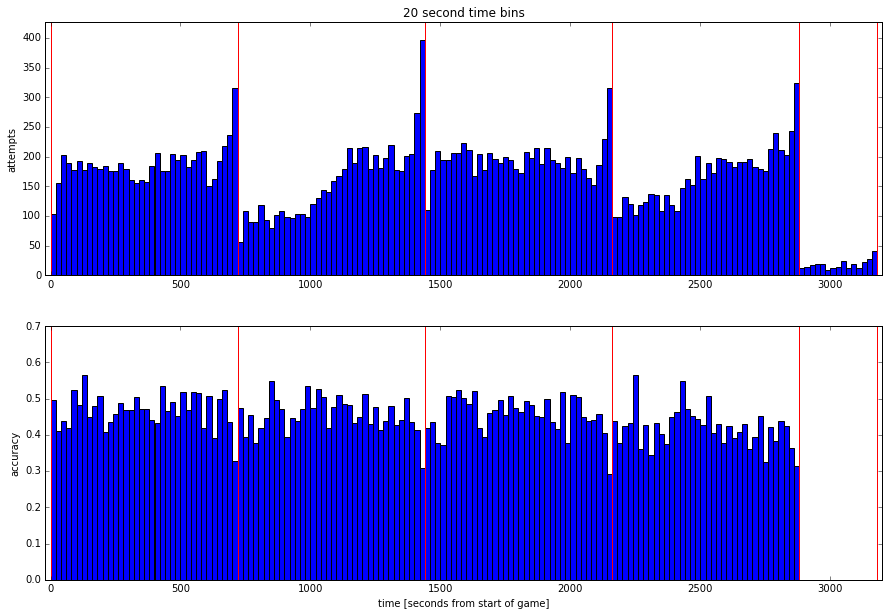

In [55]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.ix[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])
 
plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')


From shot attempts figure, it looks like Kobe is entrusted to take the last shot of every period, and he's usually on the bench at the start of 2nd and 4th periods. As the accuracy graph shows, these "last second shots" is consisently lower than usual, this is probably due to the fact that a large amonut of these shots are from very far away and in a hurry.

Now let's  examine the spatial location aspect of kobe's shots. we'll do this by building a gaussian mixture model that tries to explain Kobe's shot locations

In [58]:
#%% cluster the shot attempts of kobe using GMM on their location

numGaussians = 13
gaussianMixtureModel = mixture.GMM(n_components=numGaussians, covariance_type='full', 
                                   params='wmc', init_params='wmc',
                                   random_state=1, n_init=3,  verbose=0)
gaussianMixtureModel.fit(data.ix[:,['loc_x','loc_y']])

data['shotLocationCluster'] = gaussianMixtureModel.predict(data.ix[:,['loc_x','loc_y']])

In [59]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel._get_covars())):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=12)

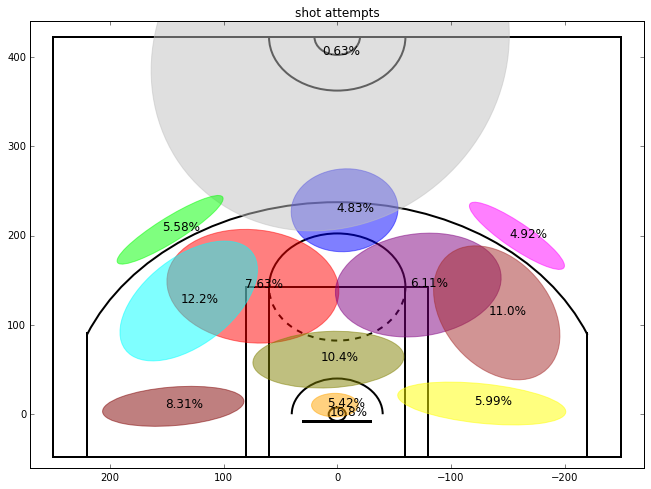

In [60]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (11, 8)

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

We can see that Kobe shots more on his right side, which is a strong side for a right hand player. Comparing to 3 point shot, Kobe prefers to shot close to basket.  

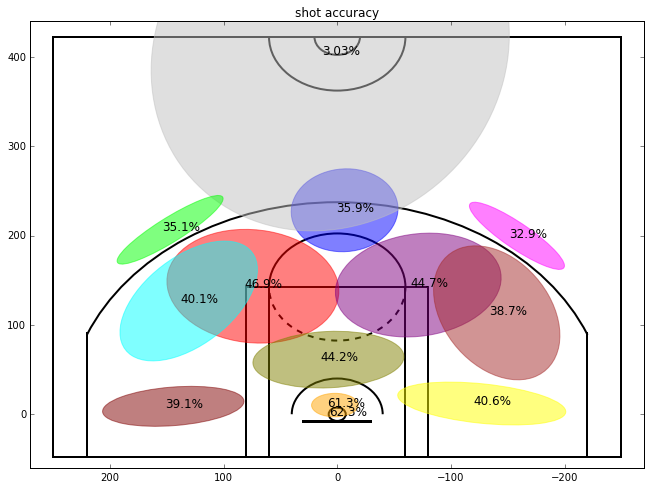

In [61]:
#%% for each cluster, calculate it's individual accuracy and plot it

plt.rcParams['figure.figsize'] = (11, 8)

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.ix[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

As it shows that, Kobe is not really good at 3 point shot, but he is strong under the basket, more than 60 percent shot accuracy. He has higher accuracy from his right side, 45 degeee shot is also his strong point.

## Algorithms and Techniques

I'm going to try different kinds of supervised learninig classification algotithms, from simple to complex, linear model such as logistic regression, nonlinear model like decision tree, and ensemble method like random forest. All the default parameters in the algorithms are the same with sklean's [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression),[DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) and [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). The data will be split into train and test set, train data set's label is <strong>shot_made_flag</strong>, data without this label is going to be in test data sets. And all the values in the data should be converted into numerical values. Then just train the algorithm on these data sets. 

## Benchmark

The benchmark value is 0.69315. It's easy to think about this hypothesis, every shot has 50-50 chance miss, so just predict 0.5 for all the data, and that will get 0.69315 score.

# Methodology

## Data Preprocessing

In [478]:
all_data = pd.read_csv('data.csv')
# drop the useless features
drop_names = ['team_name', 'team_id', 'game_id', 'lat', 'lon', 'shot_id']
all_data.drop(drop_names, axis=1, inplace=True)
# convert object features using one hot encode
convert_names = ['action_type', 'combined_shot_type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent']
for name in convert_names:
    dummies = pd.get_dummies(all_data[name]).rename(columns=lambda x: name + '_' + str(x))
    all_data = pd.concat([all_data, dummies], axis=1)
    all_data.drop(name, axis=1, inplace=True)
# convert game_date to year, month, day
col_names = ['year', 'month', 'day']
for i in range(3):
    val = all_data['game_date'].apply(lambda x:x.split('-')[i]).rename(col_names[i])
    all_data = pd.concat([all_data, val], axis=1)
# extract the information whether the game is held home from matchup
all_data = pd.concat([all_data, all_data['matchup'].apply(lambda x:1 if '@' in x else 0).rename('home')], axis=1)
all_data.drop('matchup', axis=1, inplace=True)
# convert game_event_id to shot id for kobe in that game
cnt = 1
last = -1
re_id = []
for i in range(all_data.shape[0]):
    date = all_data['game_date'][i]
    idx = all_data['game_event_id'][i]
    if date != last:
        cnt = 1
    re_id.append(cnt)
    cnt += 1
    last = date
all_data['game_event_id'].update(pd.Series(re_id))
# consider the time series features
# add a new feature, last_shot_made, whether kobe has made last shot, 
# 0.446( kobe's average shot accuracy) if it's none, 0 if it's the first shot in that game
last = 0
last_shot_made = []
for i in range(all_data.shape[0]):
    idx = all_data['game_event_id'][i]
    if idx == 1:
        last = 0
    last_shot_made.append(last)
    last = 0.446 if np.isnan(all_data['shot_made_flag'][i]) else all_data['shot_made_flag'][i]
all_data = pd.concat([all_data, pd.Series(last_shot_made,name='last_shot_made')], axis=1)
# last shot distance: Euclid distance between this shot and last shot's position, 0 if it's the first shot in the game
last_pos = np.array((0, 0))
last_shot_dis = []
for i in range(all_data.shape[0]):
    x = all_data['loc_x'][i]
    y = all_data['loc_y'][i]
    idx = all_data['game_event_id'][i]
    pos = np.array((x, y))
    dis = np.linalg.norm(pos-last_pos)
    if idx == 1:
        dis = 0
    last_shot_dis.append(dis)
    last_pos = pos
all_data = pd.concat([all_data, pd.Series(last_shot_dis,name='last_shot_dis')], axis=1)
# last_shot_gap_time: the time gap between this shot and last shot measured by second, 0 if it's the first shot
last_shot_gap_time = []
la_minute = 0
la_period = 0
la_second = 0
for i in range(all_data.shape[0]):
    minute = all_data['minutes_remaining'][i]
    period = all_data['period'][i]
    second = all_data['seconds_remaining'][i]
    idx = all_data['game_event_id'][i]
    gap = (period-la_period)*12*60 + -(minute-la_minute)*60 + -(second-la_second)
    if idx == 1 or gap<0: # there are some mistakes in the data
        gap = 0
    last_shot_gap_time.append(gap)
    la_minute, la_period, la_second = minute, period, second
all_data = pd.concat([all_data, pd.Series(last_shot_gap_time,name='last_shot_gap_time')], axis=1)
# back_to_back: whether the game is held in two successive days
back_to_back = [0]
for i in range(1, all_data.shape[0]):
    tag = 0
    if (pd.to_datetime(all_data['game_date'][i])-pd.to_datetime(all_data['game_date'][i-1])).days == 1:
        tag = 1
    if (pd.to_datetime(all_data['game_date'][i])-pd.to_datetime(all_data['game_date'][i-1])).days == 0:
        tag = back_to_back[-1]
    back_to_back.append(tag)
all_data = pd.concat([all_data, pd.Series(back_to_back,name='back_to_back')], axis=1)
# convert game date to ordered number, start from 0
order_date = sorted(all_data['game_date'])
all_data['game_date'] = all_data['game_date'].apply(lambda x:order_date.index(x))

## Implementation

In [480]:
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
import numpy as np

train_data = all_data[all_data['shot_made_flag'].notnull()]
pred_data = all_data[all_data['shot_made_flag'].isnull()].drop('shot_made_flag', axis=1)
X = train_data.drop('shot_made_flag', axis=1).values
y = train_data['shot_made_flag'].values

clfs = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]
clf_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost']
train_loss = []
val_loss = []
rs = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.1, random_state=0)
for clf in clfs:
    train_tem = []
    val_tem = []
    for train_index, test_index in rs:
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        train_tem.append(log_loss(y_train, clf.predict_proba(X_train)))
        val_tem.append(log_loss(y_test, clf.predict_proba(X_test)))
    train_loss.append(np.mean(train_tem))
    val_loss.append(np.mean(val_tem))

## Refinement

In [481]:
pd.DataFrame({'clf':clf_names, 'train_loss':train_loss, 'val_loss':val_loss})

,clf,train_loss,val_loss
0,LogisticRegression,6.112325e-01,0.611777
1,DecisionTree,9.992007e-16,14.310074
2,RandomForest,1.826032e-01,0.897065
3,GradientBoosting,5.936789e-01,0.603428
4,AdaBoost,6.883323e-01,0.688488


The initial solution result is shown above. As we can see, GradientBoosting has the best validation loss, LogisticRegression is good too, but they are underfitting, while Decision Tree and RandomForest is suffering from overfitting issues. So, I'm going to use GridSearch to find the best parameters for each model.

After a long time GridSearch, I just found that the model using default parameters has the best performance. And it seems that GradientBoostingClassifier is the best choice in this problem, but the overfitting issue is still heavy, I think maybe the features are not good enough, so I add some features, but the performance doesn't get better. 

# Results

## Model Evaluation and Validation

In [509]:
clf = GradientBoostingClassifier().fit(X, y)
print 'Log loss:', log_loss(y, clf.predict_proba(X))
print 'Accuracy:', clf.score(X, y)

Log loss: 0.594415594472
Accuracy: 0.68556640853


In [502]:
predictions = clf.predict_proba(pred_data)
out = pd.DataFrame({'shot_id':pred_data.index+1, 'shot_made_flag':[i[1] for i in predictions]})
out.to_csv('first_submission.csv', index=False)

I choose GradientBoostingClassifier as the final model, and use the default parameters. My submission in the competitin get 0.60593 score, it's way much than the benchmark 0.69315, the best score in the leader board is 0.59509, So I think this result is acceptable.

## Justification

The final result is much better than the benchmark result. But as we can see, the prediction accuracy is still not good enouch, maybe the problem target is impossible to predict well just use these features, more data should be added, something like whether kobe is guarded when he shot. Anyway, I rank 90th, and this result meet the expectation.

# Conclusion

## Free-Form Visualization

The most important thing is the data I think, and the visualization result can be seen from Exploratory Visualization part, please check. 

## Reflection

In this project, I first explore the data using some data visualization to get a sense of the data, then preproces the data and do some feature engineering, then train the model using different algorithms, and tune the model parameters using gridsearch to get the final model. I think the most interesting part in this project is the data visualization part, I can get a feel of kobe's shot ability in all kinds of aspects. And the prediction part is the most difficult part for me, the model is really hard to train, it's always suffering from underfitting or overfitting issues. The prediction accuracy is not good enough to use in reality, although it's a little better than random guess. 

## Improvement

I think there are some features I'm not using really well, that is the time series features. I just only considered the last one shot, but that's not enough. In fact, recurrent neural network is a great method to model time series data, I will try this method in future work to see if I can get better result. I think my result is still not good enough, RNN method will beat this!   